# Neural Networks
This notebook runs multiple different neural networks.

<br><br><br><br>
# Libaries & Global variables

## Libaries

In [224]:
# General libaries
import pandas as pd
import numpy as np
import os
import pickle

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# Neural network related
import keras
from keras import models
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Input
from keras import layers
from keras.preprocessing.image import ImageDataGenerator # To create an image generator to create batches of images
from keras.preprocessing import image # To change images to an np array AND visualize the image
from keras import optimizers # to optimize
from keras.models import load_model # Load model

from keras.utils.vis_utils import plot_model # To plot models
import pydot # To plot models

# Visualizing
import matplotlib.pyplot as plt

# To clear ram
from tensorflow.keras import backend as K
K.clear_session()

# To get information about ram
import multiprocessing

# Transfer Learning
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input



pd.set_option('max_colwidth', None)
pd.set_option("display.max_rows", 100)

## Global variables

In [2]:
dataset_path = os.path.join(os.getcwd(), 'datasets', 'UTKface-new-structure')

In [3]:
training_path   = os.path.join(os.getcwd(), 'datasets', 'UTKface-new-structure', 'training')
validation_path = os.path.join(os.getcwd(), 'datasets', 'UTKface-new-structure', 'validation')
test_path       = os.path.join(os.getcwd(), 'datasets', 'UTKface-new-structure', 'test')

<br><br><br><br>
# General functions

In [157]:
def load_dataset():
    """
    This function loads the dataset.
    """
    with open('df.pkl', 'rb') as input_file:
        df = pickle.load(input_file)
        
    return df


def save_history_model(history, filename, storage_location):
    """
    This function pickles the history of a model and stores it
    at the storage_location with the given filename.
    """
    
    # Pickle the result
    location = os.path.join(storage_location, filename + '.pkl')
    
    with open(location, 'wb') as output_file:
        pickle.dump(history, output_file)
        
def plot_history(history, x_as, y_as, title, line1='accuracy', line2='val_accuracy'):
    """
    This function plots two lines, which as default are accuracy
    and val_accuracy.
    """
    
    history = history.history
    
    plt.plot(range(1, len(history[line1]) + 1), history[line1])
    plt.plot(range(1, len(history[line2]) + 1), history[line2])
    plt.xlabel(x_as)
    plt.ylabel(y_as)
    plt.title(title)
    plt.legend([line1, line2])
    plt.show()
    
def load_neural_network(model_path, weights_path):
    """
    Load the model.
    """
    
    # Load model
    model = load_model(model_path)
    
    # Load weights
    model.load_weights(weights_path)
    
    # Return model
    return model

def plot_image_activation(model_path, weights_path, img_path):
    """
    This images shows the activation of the last convolutional layer.
    """
    
    # Define model
    model = load_neural_network(model_path, weights_path)
    
    # Extract model_input_shape and relevant information
    model_input_shape = model.layers[0].input_shape
    
    # Define color mode
    if model_input_shape[-1] == 1:
        color_mode = 'grayscale'
        
    elif model_input_shape[-1] == 3:
        color_mode = 'rgb'
    
    # Extract target size
    target_size = model.layers[0].input_shape[1:3]
    
    # Load the image that we want to plot
    img = image.load_img(path        = img_path,
                         color_mode  = color_mode,
                         target_size = target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    if model_input_shape[-1] == 3:
        x = preprocess_input(x)
        
    
    # Make a prediction
    preds = model.predict(x)
    
    # Get information of the prediction
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    
    for layer in model.layers:
        if 'conv' in layer.name: 
            last_conv_layer_name = layer.name
    last_conv_layer = model.get_layer(last_conv_layer_name)

    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(last_conv_layer.output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    
    # Plot the result
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img

    output = os.path.join(os.getcwd(), 'test.jpeg')
    cv2.imwrite(output, superimposed_img)

    img = mpimg.imread(output)
    
    plt.imshow(img)
    plt.axis('off')    
    
    # Delete img after showing
    os.remove(output)
    
# preds = plot_image_activation(model_path   = 'models-and-results/neural-network-2.0-lenet-5-proposed-model-model.h5', 
#                               weights_path = 'models-and-results/neural-network-2.0-lenet-5-proposed-model-weights.h5', 
#                               img_path     = r'datasets\UTKface-new-structure\test\50\42_0_0_20170117135614403.jpg')

In [5]:
df = load_dataset()
df.head()

,age,age-binned,gender,race,datetime,category,path
4,10,"(0, 10]",0,0,20161220222308131,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface-new-structure\training\10
5,10,"(0, 10]",0,0,20170103200329407,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface-new-structure\training\10
6,10,"(0, 10]",0,0,20170103200522151,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface-new-structure\training\10
7,10,"(0, 10]",0,0,20170103233459275,validation,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface-new-structure\validation\10
8,10,"(0, 10]",0,0,20170104013211746,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface-new-structure\training\10


<br><br><br><br><br><br><br><br>
# Neural Network 1.0 - LeNet-5 CNN Architecture
* Sithungu, S., & Van der Haar, D. (2019). Real-Time Age Detection Using a Convolutional Neural Network. *Business Information Systems*, 245–256. https://doi.org/10.1007/978-3-030-20482-2_20
* Information of LeNet-5 CNN architecture https://engmrk.com/lenet-5-a-classic-cnn-architecture/


<br>

The LeNet-5 structure consists of:
* Layer 1 - Input: 32x32 grayscale image with 6 feature maps of size 5x5 and stride 1.
* Layer 2 - Average pooling with filter size 2x2 and stride 2.
* Layer 3 - Conv layer with 16 feature maps of size 5x5 and stride 1.
* Layer 4 - Average pooling with filter size 2x2 and stride 2.
* Layer 5 - Fully connected layer with 120 units/feature maps of size 1x1.
* Layer 6 - Fully connected layer with 84 units.

<br>

Result:
* Loss went to nan pretty early.

<br><br>
## Functions

In [19]:
def build_dense_model():
    """
    This function creates a simple sequential neural network.
    """
    # Sequential model
    model = models.Sequential() 
    
    # Hidden layers
    model.add(layers.Conv2D(filters     = 6, 
                            kernel_size = (3,3), 
                            activation  = 'relu', 
                            input_shape = (32, 32, 1)))
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))
    
    model.add(layers.Conv2D(filters     = 16, 
                            kernel_size = (3,3), 
                            activation  = 'relu'))
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))    
    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units = 120, 
                           activation='relu'))
    model.add(layers.Dense(units = 84, 
                           activation='relu'))
    
    # Output layer
    model.add(layers.Dense(units = 7, 
                           activation='relu'))
    
    # Compiler
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])      
        
    return model

model = build_dense_model()
model.name='neural-network-1.0-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.0-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_3 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               1298040   
_________________________________________________________________
dense_5 (Dense)        

<br><br>
## Generator

In [14]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (32, 32)
COLOR_MODE  = 'grayscale'
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 15982 images belonging to 7 classes.
Found 4514 images belonging to 7 classes.
Found 2341 images belonging to 7 classes.


<br><br><br>
## Run the model

In [15]:
K.clear_session()

model = build_dense_model()
model.name='neural-network-1.0-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.0-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               1298040   
_________________________________________________________________
dense_2 (Dense)        

In [16]:
history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              workers             = (multiprocessing.cpu_count()),
                              use_multiprocessing = False  # Not sure why it should be false, gives an error when true.
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
499/499 [==============================] - 51s 102ms/step - loss: 4.3036 - accuracy: 0.3615 - val_loss: 5.2222 - val_accuracy: 0.3728
Epoch 2/15
499/499 [==============================] - 50s 101ms/step - loss: 4.2200 - accuracy: 0.3908 - val_loss: 3.6973 - val_accuracy: 0.3782
Epoch 3/15
499/499 [==============================] - 51s 102ms/step - loss: 4.2290 - accuracy: 0.4006 - val_loss: 3.0949 - val_accuracy: 0.3782
Epoch 4/15
499/499 [==============================] - 50s 101ms/step - loss: 4.2156 - accuracy: 0.4002 - val_loss: 5.7837 - val_accuracy: 0.3882
Epoch 5/15
499/499 [==============================] - 50s 100ms/step - loss: 4.2161 - accuracy: 0.4049 - val_loss: 4.1939 - val_accuracy: 0.3864
Epoch 6/15
499/499 [==============================] - 51s 102ms/step - loss: 4.1939 - accuracy: 0.4076 - val_loss: 4.6920 - val_accuracy: 0.3788
Epoch 7/15
499/499 [================

<br><br><br>
## Save results and plot results

In [17]:
# Save results
model.save_weights('models-and-results/neural-network-1.0-lenet-5-weights.h5')
model.save('models-and-results/neural-network-1.0-lenet-5-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-1.0-lenet-5-history', 
                   storage_location = 'models-and-results')

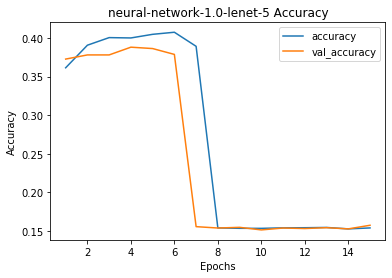

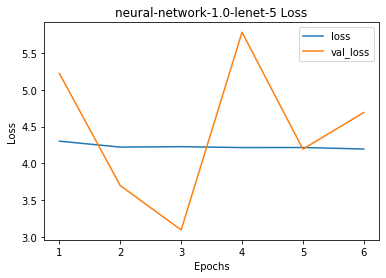

In [17]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-1.0-lenet-5 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-1.0-lenet-5 Loss')

<br><br><br><br><br><br><br><br>
# Neural Network 1.1 - LeNet-5 CNN Architecture - BatchNormalization/Softmax
Modified the original LeNet-5 structure by:
* 1. Adding **two** BatchNormalization() layers **after** the Conv2D layers. 
* 2. Adding changing the output layers to an activation **softmax** instead of the **assumed** relu.

<br><br>
## Functions

In [21]:
def build_dense_model():
    """
    This function creates a simple sequential neural network.
    """
    # Sequential model
    model = models.Sequential() 
    
    # Hidden layers
    model.add(layers.Conv2D(filters     = 6, 
                            kernel_size = (3,3), 
                            activation  = 'relu', 
                            input_shape = (32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))
    
    model.add(layers.Conv2D(filters     = 16, 
                            kernel_size = (3,3), 
                            activation  = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2), 
                                      strides   = 1))    
    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units = 120, 
                           activation='relu'))
    model.add(layers.Dense(units = 84, 
                           activation='relu'))
    
    # Output layer
    model.add(layers.Dense(units = 7, 
                           activation='softmax'))
    
    # Compiler
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])      
        
    return model

model = build_dense_model()
model.name='neural-network-1.1-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.1-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 6)         24        
_________________________________________________________________
average_pooling2d_7 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
batch_normalization_4 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
average_pooling2d_8 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)    

<br><br>
## Generator

In [22]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (32, 32)
COLOR_MODE  = 'grayscale'
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 15982 images belonging to 7 classes.
Found 4514 images belonging to 7 classes.
Found 2341 images belonging to 7 classes.


<br><br><br>
## Run the model

In [23]:
K.clear_session()

model = build_dense_model()
model.name='neural-network-1.1-LeNet-5-CNN-Architecture'
model.summary()

Model: "neural-network-1.1-LeNet-5-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 6)         24        
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        880       
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
average_pooling2d_2 (Average (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)    

In [24]:
history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              workers             = (multiprocessing.cpu_count()),
                              use_multiprocessing = False  # Not sure why it should be false, gives an error when true.
                             )

Epoch 1/15
499/499 [==============================] - 74s 147ms/step - loss: 1.8007 - accuracy: 0.3559 - val_loss: 1.7355 - val_accuracy: 0.3420
Epoch 2/15
499/499 [==============================] - 72s 145ms/step - loss: 1.5229 - accuracy: 0.4262 - val_loss: 2.1539 - val_accuracy: 0.3920
Epoch 3/15
499/499 [==============================] - 68s 136ms/step - loss: 1.3114 - accuracy: 0.5001 - val_loss: 2.0746 - val_accuracy: 0.3800
Epoch 4/15
499/499 [==============================] - 66s 132ms/step - loss: 1.0491 - accuracy: 0.6043 - val_loss: 1.4958 - val_accuracy: 0.3757
Epoch 5/15
499/499 [==============================] - 67s 134ms/step - loss: 0.7916 - accuracy: 0.7088 - val_loss: 2.2571 - val_accuracy: 0.3503
Epoch 6/15
499/499 [==============================] - 67s 133ms/step - loss: 0.5720 - accuracy: 0.7972 - val_loss: 1.5757 - val_accuracy: 0.3278
Epoch 7/15
499/499 [==============================] - 68s 135ms/step - loss: 0.4152 - accuracy: 0.8536 - val_loss: 2.2115 - val_ac

<br><br><br>
## Save results and plot results

In [26]:
# Save results
model.save_weights('models-and-results/neural-network-1.1-lenet-5-weights.h5')
model.save('models-and-results/neural-network-1.1-lenet-5-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-1.1-lenet-5-history', 
                   storage_location = 'models-and-results')

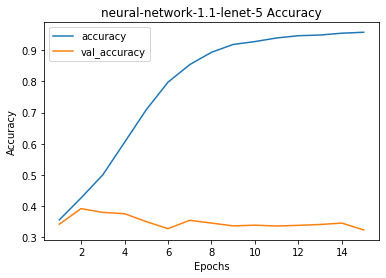

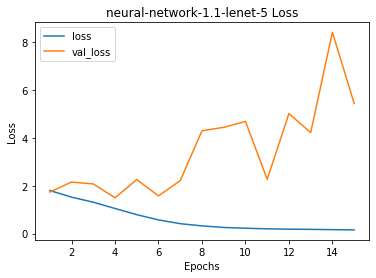

In [19]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-1.1-lenet-5 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-1.1-lenet-5 Loss')

------

<br><br><br><br>
# Neural Network 2.0 - LeNet-5 CNN (proposed improved version)

<br><br>
## Functions

In [6]:
def build_model():
    """
    This function creates a simple sequential neural network.
    """
    # Sequential model
    model = models.Sequential() 
    
    # Hidden layers
    model.add(layers.Conv2D(filters     = 6, 
                            kernel_size = (7, 7),        # Fiters from (3, 3) to (7, 7)
                            activation  = 'relu', 
                            input_shape = (200, 200, 3)))
    model.add(layers.MaxPooling2D(pool_size = (2,2), 
                                      strides   = 2))     # Assumed based on trial and error, not mentioned in the paper
    
    model.add(layers.Conv2D(filters     = 16, 
                            kernel_size = (3,3), 
                            activation  = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2), 
                                      strides   = 2))     # Assumed based on trial and error, not mentioned in the paper
    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units = 120, 
                           activation='relu'))
    model.add(layers.Dropout(rate = 0.5))                # Dropout layer added
    
    # Output layer
    model.add(layers.Dense(units = 7, 
                           activation='softmax'))        # Softmax instead of relu
    
    # Compiler
    model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])      
        
    return model

<br><br>
## Generator

In [7]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (200, 200)
COLOR_MODE  = 'rgb'
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 15990 images belonging to 7 classes.
Found 4584 images belonging to 7 classes.
Found 2263 images belonging to 7 classes.


<br><br><br>
## Run the model

In [8]:
K.clear_session()

model = build_model()
model.name='neural-network-2.0-LeNet-5-proposed-improved-CNN-Architecture'
model.summary()

Model: "neural-network-2.0-LeNet-5-proposed-improved-CNN-Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 194, 194, 6)       888       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 97, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 95, 16)        880       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 35344)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               4241400   
_________________________________________________________________
dropo

In [10]:
history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,    # Paper stated that it converged after 15/100 epochs
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              workers             = multiprocessing.cpu_count(),
                              use_multiprocessing = False  # Not sure why it should be false, gives an error when true.
                             )

Epoch 1/15
499/499 [==============================] - 714s 1s/step - loss: 1.8007 - accuracy: 0.3425 - val_loss: 1.3917 - val_accuracy: 0.3748
Epoch 2/15
499/499 [==============================] - 707s 1s/step - loss: 1.6571 - accuracy: 0.3903 - val_loss: 1.7082 - val_accuracy: 0.4062
Epoch 3/15
499/499 [==============================] - 697s 1s/step - loss: 1.5894 - accuracy: 0.4106 - val_loss: 2.1242 - val_accuracy: 0.3992
Epoch 4/15
499/499 [==============================] - 711s 1s/step - loss: 1.5565 - accuracy: 0.4285 - val_loss: 1.4861 - val_accuracy: 0.4139
Epoch 5/15
499/499 [==============================] - 691s 1s/step - loss: 1.4667 - accuracy: 0.4522 - val_loss: 1.3906 - val_accuracy: 0.4225
Epoch 6/15
499/499 [==============================] - 691s 1s/step - loss: 1.4062 - accuracy: 0.4778 - val_loss: 1.5581 - val_accuracy: 0.4238
Epoch 7/15
499/499 [==============================] - 704s 1s/step - loss: 1.3342 - accuracy: 0.5061 - val_loss: 1.7403 - val_accuracy: 0.3954

<br><br><br>
## Save results and plot results

In [13]:
# Save results
model.save_weights('models-and-results/neural-network-2.0-lenet-5-proposed-model-weights.h5')
model.save('models-and-results/neural-network-2.0-lenet-5-proposed-model-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-2.0-lenet-5-proposed-model-history', 
                   storage_location = 'models-and-results')

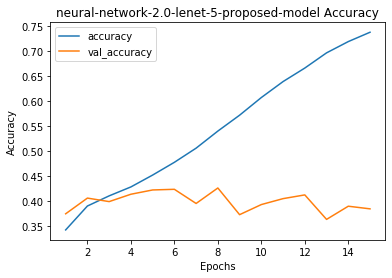

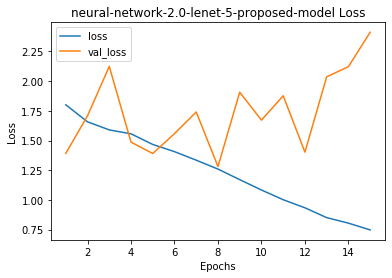

In [14]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-2.0-lenet-5-proposed-model Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-2.0-lenet-5-proposed-model Loss')

------

<br><br><br><br>
# Neural Network 3.0 - Transfer Learning - VGG16

<br><br>
## Define/import the model

In [251]:
K.clear_session()

# Generate model without top layers
vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape=(200, 200, 3))

# Extract information of the last layer of VGG16
layer_dict = dict([(layer.name, layer) for layer in vgg16.layers])
x = layer_dict[vgg16.layers[-1].name].output

# Add layers
x = Flatten()(x)
x = Dense(512, activation='relu', name='fc1')(x)           # Change this to 512 instead of 4096
x = Dense(512, activation='relu', name='fc2')(x)           # Change this to 512 instead of 4096
x = Dense(7, activation='softmax', name='predictions')(x)  # Output layer

# Combine vgg16 layer with my own layers
model = Model(input = vgg16.input, output = x)

# Freeze everything EXCEPT the last 2 FC layers (of the 3)
for layer in model.layers[:-2]:
    layer.trainable = False
    
# Add compiler
model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 

# Name the model
model.name='neural-network-3.0-transfer-learning-vgg16'

# Show summary
model.summary()

Model: "neural-network-3.0-transfer-learning-vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2

C:\Users\Paulo\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


<br><br>
## Generator

In [252]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (200, 200)
COLOR_MODE  = 'rgb'      # Model VVG16 expects rgb
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE)

Found 15982 images belonging to 7 classes.
Found 4514 images belonging to 7 classes.
Found 2341 images belonging to 7 classes.


<br><br><br>
## Run the model

In [253]:
history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,    
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              workers             = multiprocessing.cpu_count())

Epoch 1/15
499/499 [==============================] - 4893s 10s/step - loss: 1.6434 - accuracy: 0.3759 - val_loss: 1.5353 - val_accuracy: 0.4320
Epoch 2/15
499/499 [==============================] - 4520s 9s/step - loss: 1.4758 - accuracy: 0.4368 - val_loss: 1.2851 - val_accuracy: 0.4192
Epoch 3/15
499/499 [==============================] - 4533s 9s/step - loss: 1.4299 - accuracy: 0.4538 - val_loss: 1.6562 - val_accuracy: 0.4447
Epoch 4/15
499/499 [==============================] - 4517s 9s/step - loss: 1.3969 - accuracy: 0.4610 - val_loss: 1.3375 - val_accuracy: 0.4523
Epoch 5/15
499/499 [==============================] - 4515s 9s/step - loss: 1.3634 - accuracy: 0.4770 - val_loss: 1.4738 - val_accuracy: 0.4326
Epoch 6/15
499/499 [==============================] - 4610s 9s/step - loss: 1.3376 - accuracy: 0.4888 - val_loss: 1.7146 - val_accuracy: 0.4514
Epoch 7/15
499/499 [==============================] - 4616s 9s/step - loss: 1.3074 - accuracy: 0.4979 - val_loss: 1.7574 - val_accuracy

<br><br><br>
## Save results and plot results

In [256]:
# Save results
model.save_weights('models-and-results/neural-network-3.0-transfer-learning-vgg16-weights.h5')
model.save('models-and-results/neural-network-3.0-transfer-learning-vgg16-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-3.0-transfer-learning-vgg16-history', 
                   storage_location = 'models-and-results')

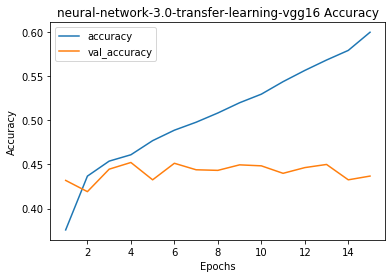

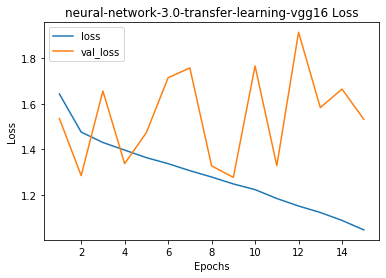

In [257]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-3.0-transfer-learning-vgg16 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-3.0-transfer-learning-vgg16 Loss')